# Neural Network Modelling for Glacier Mass Balance Prediction

This notebook implements **neural network models** for predicting glacier point mass balance measurements using meteorological and topographical features. The notebook supports two main modelling approaches:

##  **Modelling Strategies**

### 1. **Regional Modelling (Norway Only)**
- Train and test exclusively on Norwegian glacier data
- Uses glacier-based train/test splits to ensure spatial generalization

### 2. **Cross-Regional Modelling (Switzerland → Norway)**
- Combines data from Swiss glaciers and Norway glaciers
- Can be used as either a cross-regional model, training exclusively on Swiss data and testing on Norwegian data
- or as a baseline for transfer learning models, training on Swiss data and a subset of Norwegian data and testing on remaining Norwegian data


---

##  **Prerequisites**
- Norwegian glacier dataset from `../1.1. Norway-prepro.ipynb`
- Swiss glacier dataset from `regions/Switzerland/1.1. GLAMOS-prepro.ipynb`
- ERA5 climate data for both regions from `../1.2. ERA5Land-prepro.ipynb`
---

### Feature Definitions

**Climate Features (ERA5 Reanalysis):**
- `t2m`: 2-meter temperature
- `tp`: Total precipitation
- `slhf`/`sshf`: Surface heat fluxes
- `ssrd`: Surface solar radiation downwards
- `fal`: Albedo
- `str`: Surface net thermal radiation
- `u10`/`v10`: Wind components

**Topographical Features (OGGM):**
- `aspect`/`slope`: Terrain geometry
- `hugonnet_dhdt`: Ice thickness changes
- `consensus_ice_thickness`: Ice depth
- `millan_v`: Ice surface velocity
- `elevation_difference`: Measurement elevation − ERA5-Land grid cell elevation

## Environment Setup & Configuration

In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../')) # Add root of repo to import MBM

import pandas as pd
import numpy as np
import warnings
import re
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging
import torch.nn as nn
from skorch.helper import SliceDataset
from datetime import datetime
from skorch.callbacks import EarlyStopping, LRScheduler, Checkpoint
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset
import pickle
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from scripts.helpers import *
from scripts.norway_preprocess import *
from scripts.plots import *
from scripts.config_NOR import *
from scripts.nn_helpers import *
from scripts.xgb_helpers import *
from scripts.NN_networks import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

cfg = mbm.NorwayConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/')

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect", # OGGM
    "slope", # OGGM
    "hugonnet_dhdt",  # OGGM
    "consensus_ice_thickness",  # OGGM
    "millan_v",
]

In [3]:
seed_all(cfg.seed)

if torch.cuda.is_available():
    print("CUDA is available")
    free_up_cuda()

else:
    print("CUDA is NOT available")


CUDA is available


## A. Regional Modelling (Norway Only)

This approach trains neural networks exclusively on Norwegian glacier data.

## Data Loading & Initial Processing

### Create Norwegian Glacier Dataset

Start with point mass balance measurements and transform them to monthly format with ERA5 climate data.

In [4]:
data_wgms = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'Nor_dataset_all_oggm_with_millanv.csv')
# Drop Nan entries in millan_v of Norway dataset
data_wgms = data_wgms.dropna(subset=data_wgms.columns.drop('DATA_MODIFICATION'))

print('Number of glaciers:', len(data_wgms['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_wgms[data_wgms.PERIOD == 'annual']) + len(data_wgms[data_wgms.PERIOD == 'winter']) + len(data_wgms[data_wgms.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_wgms[data_wgms.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_wgms[data_wgms.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_wgms[data_wgms.PERIOD == 'summer']))

data_wgms.columns


Number of glaciers: 31
Number of winter, summer and annual samples: 5959
Number of annual samples: 3022
Number of winter samples: 2937
Number of summer samples: 0


Index(['POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE', 'TO_DATE',
       'POINT_BALANCE', 'PERIOD', 'RGIId', 'YEAR', 'GLACIER',
       'DATA_MODIFICATION', 'POINT_ID', 'aspect', 'slope', 'topo',
       'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v'],
      dtype='object')

### Dataset Transformation to Monthly Format

Transform point mass balance data to monthly resolution and integrate with ERA5 climate variables.

In [5]:
data_wgms_test = data_wgms.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_NOR_CH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_NOR_CH.nc'
}

RUN = False
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_wgms_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file='NOR_dataset_monthly_full_with_millanv.csv')
data_monthly = dataloader_gl.data

display(data_monthly.head(2))

2025-10-15 16:57:54,705 - INFO - Loaded preprocessed data.
2025-10-15 16:57:54,707 - INFO - Number of monthly rows: 56965
2025-10-15 16:57:54,717 - INFO - Number of annual samples: 36350
2025-10-15 16:57:54,723 - INFO - Number of winter samples: 20615


,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,millan_v,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10
0,2013,16.04244,67.31103,-5.63,930.332494,11.667506,942,RGI60-08.02384,Rundvassbreen_2013_annual_67.31103_16.04244_N_...,0,...,69.698883,-3.957367,0.002545,-120958.0,132238.0,2673505.0,0.518889,-2003158.0,-0.577771,0.414947
1,2013,16.04244,67.31103,-5.63,930.332494,11.667506,942,RGI60-08.02384,Rundvassbreen_2013_annual_67.31103_16.04244_N_...,0,...,69.698883,-7.107025,0.003408,107086.0,467112.0,414668.0,0.838310,-1135388.0,-1.247729,1.351297


### Train/Test Splitting Strategy

**Spatial Generalization Approach:** Select test set based on glaciers, remaining glaciers will be the train set

In [ ]:
test_glaciers = ['Cainhavarre', 'Rundvassbreen', 'Svartisheibreen', 'Trollbergdalsbreen', 'Hansebreen', 'Tunsbergdalsbreen', 'Austdalsbreen', 'Hellstugubreen', 'Austre Memurubreen', 'Bondhusbrea', 'Svelgjabreen', 'Moesevassbrea', 'Blomstoelskardsbreen']

"""
# 50% 
test_glaciers = ['Cainhavarre',
 'Svartisheibreen',
 'Hoegtuvbreen',
 'Trollbergdalsbreen',
 'Ruklebreen',
 'Graafjellsbrea',
 'Breidablikkbrea',
 'Bondhusbrea',
 'Tunsbergdalsbreen',
 'Hellstugubreen',
 'Vesledalsbreen',
 'Nigardsbreen',
 'Rembesdalskaaka']
"""             

"""  
# 5-10% 7 glaciers
test_glaciers = ['Rundvassbreen', 'Engabreen', 'Aalfotbreen', 'Hansebreen', 'Nigardsbreen',
                'Austdalsbreen', 'Juvfonne', 'Hellstugubreen', 'Rembesdalskaaka',
                'Svelgjabreen', 'Blomstoelskardsbreen', 'Storsteinsfjellbreen',
                'Trollbergdalsbreen', 'Vetlefjordbreen', 'Storglombreen N', 'Graafjellsbrea',
                'Breidablikkbrea', 'Blaaisen', 'Blabreen', 'Ruklebreen', 'Cainhavarre',
                'Vesledalsbreen', 'Vestre Memurubreen', 'Hoegtuvbreen']
"""  

# 63 lat split
#test_glaciers = ['Rundvassbreen', 'Engabreen', 'Storsteinsfjellbreen', 'Svartisheibreen', 'Trollbergdalsbreen', 'Storglombreen N', 'Blaaisen', 'Cainhavarre', 'Hoegtuvbreen']

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

Size of test data: 14197
Size of train data: 42768
Percentage of test size: 33.20%
Train glaciers: (18) ['Engabreen' 'Aalfotbreen' 'Nigardsbreen' 'Juvfonne' 'Rembesdalskaaka'
 'Storsteinsfjellbreen' 'Vetlefjordbreen' 'Harbardsbreen'
 'Storglombreen N' 'Graafjellsbrea' 'Breidablikkbrea' 'Graasubreen'
 'Blaaisen' 'Blabreen' 'Ruklebreen' 'Vesledalsbreen' 'Vestre Memurubreen'
 'Hoegtuvbreen']
Test glaciers: (13) ['Rundvassbreen' 'Hansebreen' 'Austdalsbreen' 'Hellstugubreen'
 'Svelgjabreen' 'Blomstoelskardsbreen' 'Moesevassbrea' 'Svartisheibreen'
 'Trollbergdalsbreen' 'Cainhavarre' 'Tunsbergdalsbreen'
 'Austre Memurubreen' 'Bondhusbrea']


### Training/Validation Split Strategy (80/20)

**Standard Approach:** Random 80/20 split across all available training data.

In [24]:
# Validation and train split:
data_train = train_set['df_X']
data_train['y'] = train_set['y']
dataloader = mbm.dataloader.DataLoader(cfg, data=data_train)

train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

# Get all indices of the training and valing dataset at once from the iterators. Once called, the iterators are empty.
train_indices, val_indices = list(train_itr), list(val_itr)

df_X_train = data_train.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get val set
df_X_val = data_train.iloc[val_indices]
y_val = df_X_val['POINT_BALANCE'].values

## B. Cross-Regional Transfer Learning (Switzerland → Norway)

This approach uses the rich Swiss dataset to try and modell Norwegian glaciers. Either purely cross-regional (no Norwegian data seen by the model during training), or as a baseline for transfer learning by including a subset of Norwegian data into training.


### Create Combined Swiss and Norwegian Glacier Dataset

Start with point mass balance measurements and transform them to monthly format with ERA5 climate data.

In [ ]:
data_CH = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/CH_wgms_dataset_all_04_06_oggm.csv')
data_NOR = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'Nor_dataset_all_oggm_with_millanv.csv')

# Drop Nan entries in millan_v of Norway dataset
data_NOR = data_NOR.dropna(subset=data_NOR.columns.drop('DATA_MODIFICATION'))
display(data_NOR)

display(data_CH.columns)

display(data_NOR.columns)

data_CH = data_CH.drop(['aspect_sgi', 'slope_sgi', 'topo_sgi'], axis=1)

display(data_CH.columns)

# Merge CH with NOR
data_NOR_CH = pd.concat([data_NOR, data_CH], axis=0).reset_index(drop=True)

display(data_NOR_CH.head(2))


### Dataset Transformation to Monthly Format

Transform point mass balance data to monthly resolution and integrate with ERA5 climate variables.

In [5]:
data_CH_NOR_test = data_NOR_CH.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_NOR_CH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_NOR_CH.nc'
}

RUN = False
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_CH_NOR_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'CH_NOR_wgms_dataset_monthly_full_with_millanv_v2.csv')
data_monthly_CH_NOR = dataloader_gl.data

display(data_monthly_CH_NOR.head(2))

2025-09-29 07:41:46,481 - INFO - Loaded preprocessed data.
2025-09-29 07:41:46,486 - INFO - Number of monthly rows: 347647
2025-09-29 07:41:46,527 - INFO - Number of annual samples: 123790
2025-09-29 07:41:46,571 - INFO - Number of winter samples: 223857


,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,millan_v,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10
0,2013,16.04244,67.31103,-5.63,930.332494,11.667506,942.0,RGI60-08.02384,Rundvassbreen_2013_annual_67.31103_16.04244_N_...,0,...,69.698883,-3.957367,0.002545,-120958.0,132238.0,2673505.0,0.518889,-2003158.0,-0.577771,0.414947
1,2013,16.04244,67.31103,-5.63,930.332494,11.667506,942.0,RGI60-08.02384,Rundvassbreen_2013_annual_67.31103_16.04244_N_...,0,...,69.698883,-7.107025,0.003408,107086.0,467112.0,414668.0,0.838310,-1135388.0,-1.247729,1.351297


### Train/Test Splitting Strategy

**Spatial Generalization Approach:** Select test set based on glaciers, remaining glaciers will be the train set

In [ ]:
test_glaciers = list(data_NOR['GLACIER'].unique())

"""
# 50%
test_glaciers = ['Cainhavarre',
 'Svartisheibreen',
 'Hoegtuvbreen',
 'Trollbergdalsbreen',
 'Ruklebreen',
 'Graafjellsbrea',
 'Breidablikkbrea',
 'Bondhusbrea',
 'Tunsbergdalsbreen',
 'Hellstugubreen',
 'Vesledalsbreen',
 'Nigardsbreen',
 'Rembesdalskaaka']
"""

"""
# 5-10% 7 glaciers
test_glaciers = ['Rundvassbreen', 'Engabreen', 'Aalfotbreen', 'Hansebreen', 'Nigardsbreen',
                'Austdalsbreen', 'Juvfonne', 'Hellstugubreen', 'Rembesdalskaaka',
                'Svelgjabreen', 'Blomstoelskardsbreen', 'Storsteinsfjellbreen',
                'Trollbergdalsbreen', 'Vetlefjordbreen', 'Storglombreen N', 'Graafjellsbrea',
                'Breidablikkbrea', 'Blaaisen', 'Blabreen', 'Ruklebreen', 'Cainhavarre',
                'Vesledalsbreen', 'Vestre Memurubreen', 'Hoegtuvbreen']
"""
"""
# north/south 63 lat split
test_glaciers = ['Rundvassbreen', 'Engabreen', 'Storsteinsfjellbreen', 'Svartisheibreen',
                'Trollbergdalsbreen', 'Storglombreen N', 'Blaaisen', 'Cainhavarre', 'Hoegtuvbreen']
"""

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = list(data_CH['GLACIER'].unique())
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))


Size of test data: 56965
Size of train data: 290682
Percentage of test size: 19.60%
Train glaciers: (39) ['adler' 'albigna' 'aletsch' 'allalin' 'basodino' 'cantun' 'chessjen'
 'clariden' 'corbassiere' 'corvatsch' 'damma' 'findelen' 'forno' 'gietro'
 'gorner' 'gries' 'hohlaub' 'joeri' 'limmern' 'morteratsch' 'murtel'
 'oberaar' 'otemma' 'pizol' 'plainemorte' 'plattalva' 'rhone' 'sanktanna'
 'sardona' 'schwarzbach' 'schwarzberg' 'sexrouge' 'silvretta'
 'taelliboden' 'tiefen' 'tortin' 'tsanfleuron' 'vorab' 'witenwasseren']
Test glaciers: (31) ['Rundvassbreen' 'Engabreen' 'Aalfotbreen' 'Hansebreen' 'Nigardsbreen'
 'Austdalsbreen' 'Juvfonne' 'Hellstugubreen' 'Rembesdalskaaka'
 'Svelgjabreen' 'Blomstoelskardsbreen' 'Moesevassbrea'
 'Storsteinsfjellbreen' 'Svartisheibreen' 'Trollbergdalsbreen'
 'Vetlefjordbreen' 'Harbardsbreen' 'Storglombreen N' 'Graafjellsbrea'
 'Breidablikkbrea' 'Graasubreen' 'Blaaisen' 'Blabreen' 'Ruklebreen'
 'Cainhavarre' 'Tunsbergdalsbreen' 'Vesledalsbreen' 'Austre Memu

### Training/Validation Split Strategy (80/20)

**Standard Approach:** Random 80/20 split across all available training data (Swiss + Norwegian training glaciers).

In [7]:
# Validation and train split:
data_train = train_set['df_X']
data_train['y'] = train_set['y']
dataloader = mbm.dataloader.DataLoader(cfg, data=data_train)

train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

# Get all indices of the training and valing dataset at once from the iterators. Once called, the iterators are empty.
train_indices, val_indices = list(train_itr), list(val_itr)

df_X_train = data_train.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get val set
df_X_val = data_train.iloc[val_indices]
y_val = df_X_val['POINT_BALANCE'].values

print("Train indices (first 10):", train_indices[:10])
print("Val indices (first 10):", val_indices[:10])
print("Train data glacier distribution:", df_X_train['GLACIER'].value_counts().head())
print("Val data glacier distribution:", df_X_val['GLACIER'].value_counts().head())
print("Train data shape:", df_X_train.shape)
print("Val data shape:", df_X_val.shape)

Train indices (first 10): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Val indices (first 10): [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Train data glacier distribution: GLACIER
rhone        44801
silvretta    35784
findelen     26724
gries        20271
aletsch      13057
Name: count, dtype: int64
Val data glacier distribution: GLACIER
rhone        11272
silvretta     8693
findelen      6833
gries         5432
aletsch       3212
Name: count, dtype: int64
Train data shape: (232694, 29)
Val data shape: (57988, 29)


### Training/Validation Split - Target Domain Focus (80/20)

**Domain-Aware Approach:** This split will only build the validation set from Norwegian data

- **Training Set:** All Swiss data + 80% of Norwegian training glaciers
- **Validation Set:** 20% of Norwegian training glaciers only

This ensures that the same validation set is used as in fine-tuning and layer freezing in the `../3.2.4 Train-ML-model-NN_progressive_transfer` Notebook.

In [7]:
# Full training pool = CH + Norway subset
data_train = train_set['df_X'].copy()
data_train['y'] = train_set['y']

# Norway train_glaciers
norway_train_glacier = [
    g for g in data_NOR['GLACIER'].unique()
    if g not in test_glaciers
]
display('train glaciers from target domain: ', norway_train_glacier)

# Find Norway subset within this pool
norway_mask = data_train['GLACIER'].isin(norway_train_glacier)
data_norway = data_train.loc[norway_mask]

# Split only the Norway subset
dataloader = mbm.dataloader.DataLoader(cfg, data=data_norway)
train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

norway_train_idx = list(train_itr)
norway_val_idx = list(val_itr)

# Training set = CH + Norway train portion
df_X_train = pd.concat([
    data_train.loc[~norway_mask],                           # all CH glaciers
    data_norway.iloc[norway_train_idx]                    # Norway train glaciers
])
y_train = df_X_train['POINT_BALANCE'].values

# Validation set = Norway val portion only
df_X_val = data_norway.iloc[norway_val_idx]
y_val = df_X_val['POINT_BALANCE'].values


print("Train data glacier distribution:", df_X_train['GLACIER'].value_counts().head())
print("Val data glacier distribution:", df_X_val['GLACIER'].value_counts().head())
print("Train data shape:", df_X_train.shape)
print("Val data shape:", df_X_val.shape)


'train glaciers from target domain: '

[]

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

## Neural Network Configuration & Training


Implementing a **Multilayer perceptron deep neural network** designed specifically for glacier mass balance prediction


The following cell is optional and initializes a period_indicator variable, which allows the NN to keep track if the current point is from a winter or annual measurement.

Uncomment `#+ ['PERIOD_INDICATOR']` in the "Define features" cell if you want to use this feature.

In [8]:
def create_period_indicator(df):
    """Create numerical PERIOD_INDICATOR feature"""
    df = df.copy()
    df['PERIOD_INDICATOR'] = df['PERIOD'].map({'annual': 0, 'winter': 1})
    return df

# Apply to all datasets
df_X_train = create_period_indicator(df_X_train)
df_X_val = create_period_indicator(df_X_val)
test_set['df_X'] = create_period_indicator(test_set['df_X'])

print("PERIOD_INDICATOR created:")
print("Annual (0):", (df_X_train['PERIOD_INDICATOR'] == 0).sum())
print("Winter (1):", (df_X_train['PERIOD_INDICATOR'] == 1).sum())
print("Original PERIOD column preserved:", df_X_train['PERIOD'].unique())

PERIOD_INDICATOR created:
Annual (0): 70474
Winter (1): 162220
Original PERIOD column preserved: ['annual' 'winter']


Define features

In [ ]:
features_topo = [
    'ELEVATION_DIFFERENCE',
] + list(vois_topographical)

feature_columns = features_topo + list(vois_climate) #  + ['PERIOD_INDICATOR']

cfg.setFeatures(feature_columns)

all_columns = feature_columns + cfg.fieldsNotFeatures

df_X_train_subset = df_X_train[all_columns]
df_X_val_subset = df_X_val[all_columns]
df_X_test_subset = test_set['df_X'][all_columns]

print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of validation dataset:', df_X_val_subset.shape)
print('Shape of testing dataset:', df_X_test_subset.shape)
print('Running with features:', feature_columns)

assert all(train_set['df_X'].POINT_BALANCE == train_set['y'])

Shape of training dataset: (42626, 28)
Shape of validation dataset: (10788, 28)
Shape of testing dataset: (3551, 28)
Running with features: ['ELEVATION_DIFFERENCE', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10']


In [10]:
# Check the current Norway feature order
print("Current Norway feature order:")
for i, feature in enumerate(feature_columns):
    print(f"{i}: {feature}")

Current Norway feature order:
0: ELEVATION_DIFFERENCE
1: aspect
2: slope
3: hugonnet_dhdt
4: consensus_ice_thickness
5: millan_v
6: t2m
7: tp
8: slhf
9: sshf
10: ssrd
11: fal
12: str
13: u10
14: v10
15: PERIOD_INDICATOR


### Network Initialization & Hyperparameters

**NN Configuration:**
- **Learning Rate:** 0.001 with ReduceLROnPlateau scheduling
- **Batch Size:** 128 samples per gradient update  
- **Optimization:** Adam optimizer with L2 weight decay (1e-5)
- **Architecture:** [128, 128, 64, 32] hidden layers with 20% dropout
- **Regularization:** Batch normalization + early stopping (patience=15)

**Callbacks for Robust Training:**
- **Early Stopping:** Prevents overfitting by monitoring validation loss
- **Learning Rate Scheduler:** Reduces LR when validation loss plateaus

In [ ]:
early_stop = EarlyStopping(
    monitor='valid_loss',
    patience=15,
    threshold=1e-4,  # Optional: stop only when improvement is very small
)

lr_scheduler_cb = LRScheduler(policy=ReduceLROnPlateau,
                              monitor='valid_loss',
                              mode='min',
                              factor=0.5,
                              patience=5,
                              threshold=0.01,
                              threshold_mode='rel',
                              verbose=True)

dataset = dataset_val = None  # Initialized hereafter


def my_train_split(ds, y=None, **fit_params):
    return dataset, dataset_val


# param_init = {'device': 'cuda:0'}
param_init = {'device': 'cpu'}  # Use CPU for training
nInp = len(feature_columns)

params = {
    'lr': 0.001,
    'batch_size': 128,
    'optimizer': torch.optim.Adam,
    'optimizer__weight_decay': 1e-05,
    'module__hidden_layers': [128, 128, 64, 32],
    'module__dropout': 0.2,
    'module__use_batchnorm': True,
}

args = {
    'module': FlexibleNetwork,
    'nbFeatures': nInp,
    'module__input_dim': nInp,
    'module__dropout': params['module__dropout'],
    'module__hidden_layers': params['module__hidden_layers'],
    'train_split': my_train_split,
    'batch_size': params['batch_size'],
    'verbose': 1,
    'iterator_train__shuffle': True,
    'lr': params['lr'],
    'max_epochs': 200,
    'optimizer': params['optimizer'],
    'optimizer__weight_decay': params['optimizer__weight_decay'],
    'module__use_batchnorm': params['module__use_batchnorm'],
    'callbacks': [
        ('early_stop', early_stop),
        ('lr_scheduler', lr_scheduler_cb),
    ]
}
custom_nn = mbm.models.CustomNeuralNetRegressor(cfg, **args, **param_init)

### Dataset Preparation for Neural Network Training

In [27]:
features, metadata = custom_nn._create_features_metadata(df_X_train_subset)

features_val, metadata_val = custom_nn._create_features_metadata(
    df_X_val_subset)

# Define the dataset for the NN
dataset = mbm.data_processing.AggregatedDataset(cfg,
                                                features=features,
                                                metadata=metadata,
                                                targets=y_train)
dataset = mbm.data_processing.SliceDatasetBinding(SliceDataset(dataset, idx=0),
                                                  SliceDataset(dataset, idx=1))
print("train:", dataset.X.shape, dataset.y.shape)

dataset_val = mbm.data_processing.AggregatedDataset(cfg,
                                                    features=features_val,
                                                    metadata=metadata_val,
                                                    targets=y_val)
dataset_val = mbm.data_processing.SliceDatasetBinding(
    SliceDataset(dataset_val, idx=0), SliceDataset(dataset_val, idx=1))
print("validation:", dataset_val.X.shape, dataset_val.y.shape)

train: (4480,) (4480,)
validation: (1120,) (1120,)


### Model Training & Checkpointing

Set `TRAIN = True` to train new model.

Training the model...
Model parameters:
module: <class 'scripts.NN_networks.FlexibleNetwork'>
nbFeatures: 15
module__input_dim: 15
module__dropout: 0.2
module__hidden_layers: [128, 128, 64, 32]
train_split: <function my_train_split at 0x7a60cd4825c0>
batch_size: 128
verbose: 1
iterator_train__shuffle: True
lr: 0.001
max_epochs: 200
optimizer: <class 'torch.optim.adam.Adam'>
optimizer__weight_decay: 1e-05
module__use_batchnorm: True
callbacks: [('early_stop', <skorch.callbacks.training.EarlyStopping object at 0x7a60cd42ebd0>), ('lr_scheduler', <skorch.callbacks.lr_scheduler.LRScheduler object at 0x7a60cd578950>)]
  epoch    train_loss    valid_loss      lr     dur
-------  ------------  ------------  ------  ------
      1        2.8731        3.5977  0.0010  2.6449
      2        1.6958        1.0184  0.0010  2.5063
      3        1.5902        1.4754  0.0010  2.4395
      4        1.4033        0.8954  0.0010  2.6828
      5        1.3385        0.9647  0.0010  2.4100
      6        1

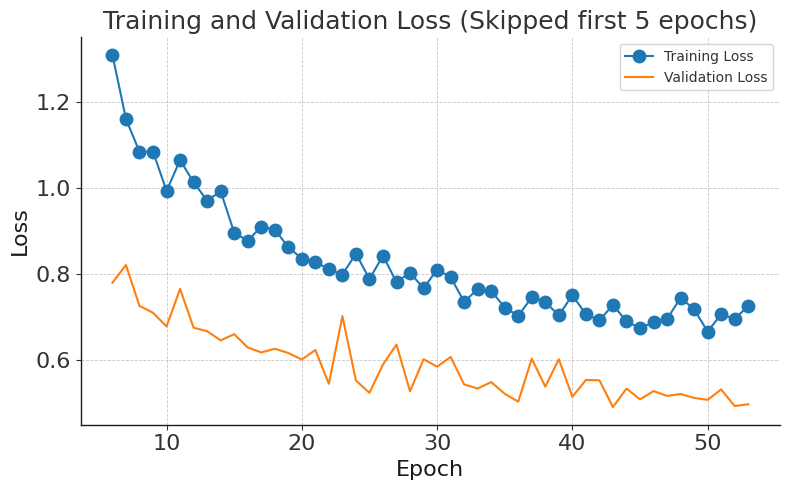

In [28]:
TRAIN = True
if TRAIN:
    custom_nn.seed_all()

    print("Training the model...")
    print('Model parameters:')
    for key, value in args.items():
        print(f"{key}: {value}")
    custom_nn.fit(dataset.X, dataset.y)
    # The dataset provided in fit is not used as the datasets are overwritten in the provided train_split function

    # Generate filename with current date
    current_date = datetime.now().strftime("%Y-%m-%d")
    model_filename = f"nn_model_{current_date}"

    plot_training_history(custom_nn, skip_first_n=5)

    # After Training: Best weights are already loaded
    # Save the model
    custom_nn.save_model(model_filename)
    
    # save params dic
    params_filename = f"nn_params_{current_date}.pkl"

    with open(f"models/{params_filename}", "wb") as f:
        pickle.dump(args, f)

Load previously trained model.

In [30]:
model_filename = "nn_model_2025-09-30.pt"  # Replace with actual date if needed

loaded_model = mbm.models.CustomNeuralNetRegressor.load_model(
    cfg,
    model_filename,
    **{
        **args,
        **param_init
    },
)
loaded_model = loaded_model.set_params(device='cpu')
loaded_model = loaded_model.to('cpu')

### Model Evaluation & Prediction Analysis

In [31]:
# Create features and metadata
features_test, metadata_test = loaded_model._create_features_metadata(
    df_X_test_subset)

# Ensure all tensors are on CPU if they are torch tensors
if hasattr(features_test, 'cpu'):
    features_test = features_test.cpu()

# Ensure targets are also on CPU
targets_test = test_set['y']
if hasattr(targets_test, 'cpu'):
    targets_test = targets_test.cpu()

# Create the dataset
dataset_test = mbm.data_processing.AggregatedDataset(cfg,
                                                     features=features_test,
                                                     metadata=metadata_test,
                                                     targets=targets_test)

dataset_test = [
    SliceDataset(dataset_test, idx=0),
    SliceDataset(dataset_test, idx=1)
]

# Make predictions aggr to meas ID
y_pred = loaded_model.predict(dataset_test[0])
y_pred_agg = loaded_model.aggrPredict(dataset_test[0])

batchIndex = np.arange(len(y_pred_agg))
y_true = np.array([e for e in dataset_test[1][batchIndex]])

# Calculate scores
score = loaded_model.score(dataset_test[0], dataset_test[1])
mse, rmse, mae, pearson = loaded_model.evalMetrics(y_pred, y_true)

# Aggregate predictions
id = dataset_test[0].dataset.indexToId(batchIndex)
data = {
    'target': [e[0] for e in dataset_test[1]],
    'ID': id,
    'pred': y_pred_agg
}
grouped_ids = pd.DataFrame(data)

# Add period
periods_per_ids = df_X_test_subset.groupby('ID')['PERIOD'].first()
grouped_ids = grouped_ids.merge(periods_per_ids, on='ID')

# Add glacier name
glacier_per_ids = df_X_test_subset.groupby('ID')['GLACIER'].first()
grouped_ids = grouped_ids.merge(glacier_per_ids, on='ID')

# Add YEAR
years_per_ids = df_X_test_subset.groupby('ID')['YEAR'].first()
grouped_ids = grouped_ids.merge(years_per_ids, on='ID')

Save results

In [ ]:
# Save individual grouped_ids as CSV
split_name = "cross_regional_all_CH_NOR_periodindicator"
csv_filename = f"grouped_ids_{split_name.replace('%', 'pct').replace('-', '_')}.csv"
grouped_ids.to_csv(f"results/{csv_filename}", index=False)

split_name = "cross_regional_all_CH_NOR_periodindicator" 
csv_filename = f"results/grouped_ids_{split_name}.csv"

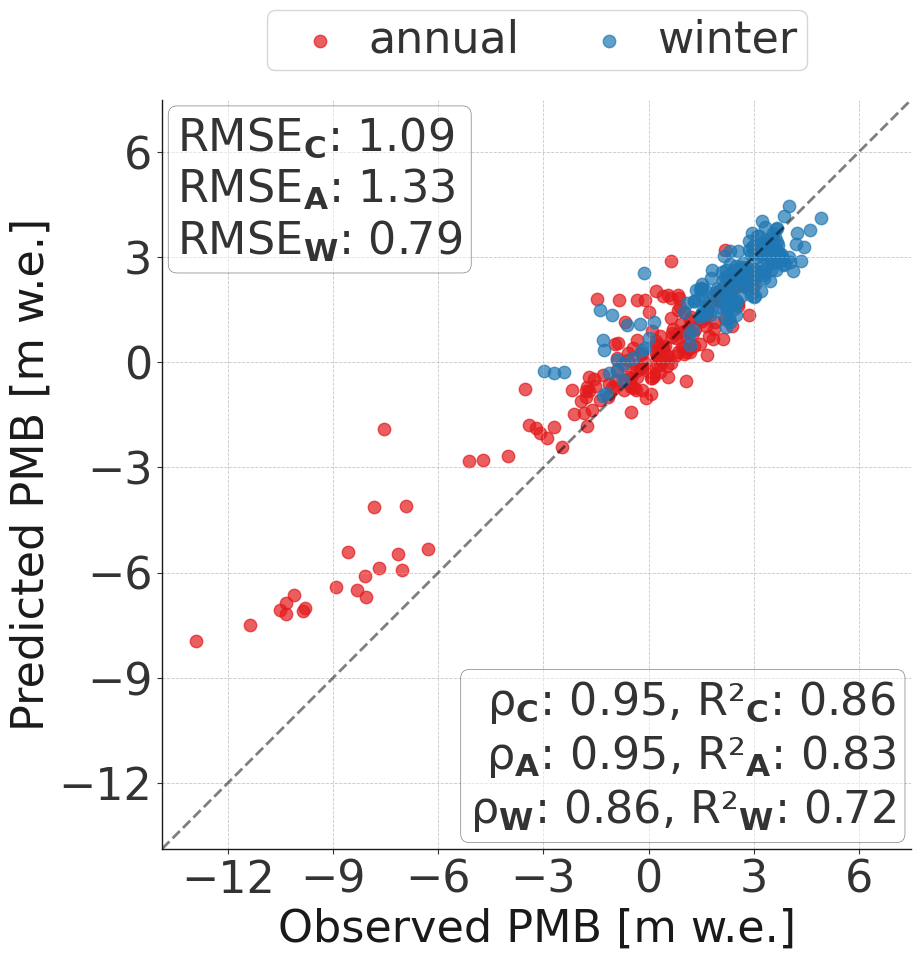

In [ ]:
PlotPredictionsCombined_NN_additional(grouped_ids, region_name='CH Train NOR Test', nticks=8, min_val=-12.9, max_val=6.510000000000001)

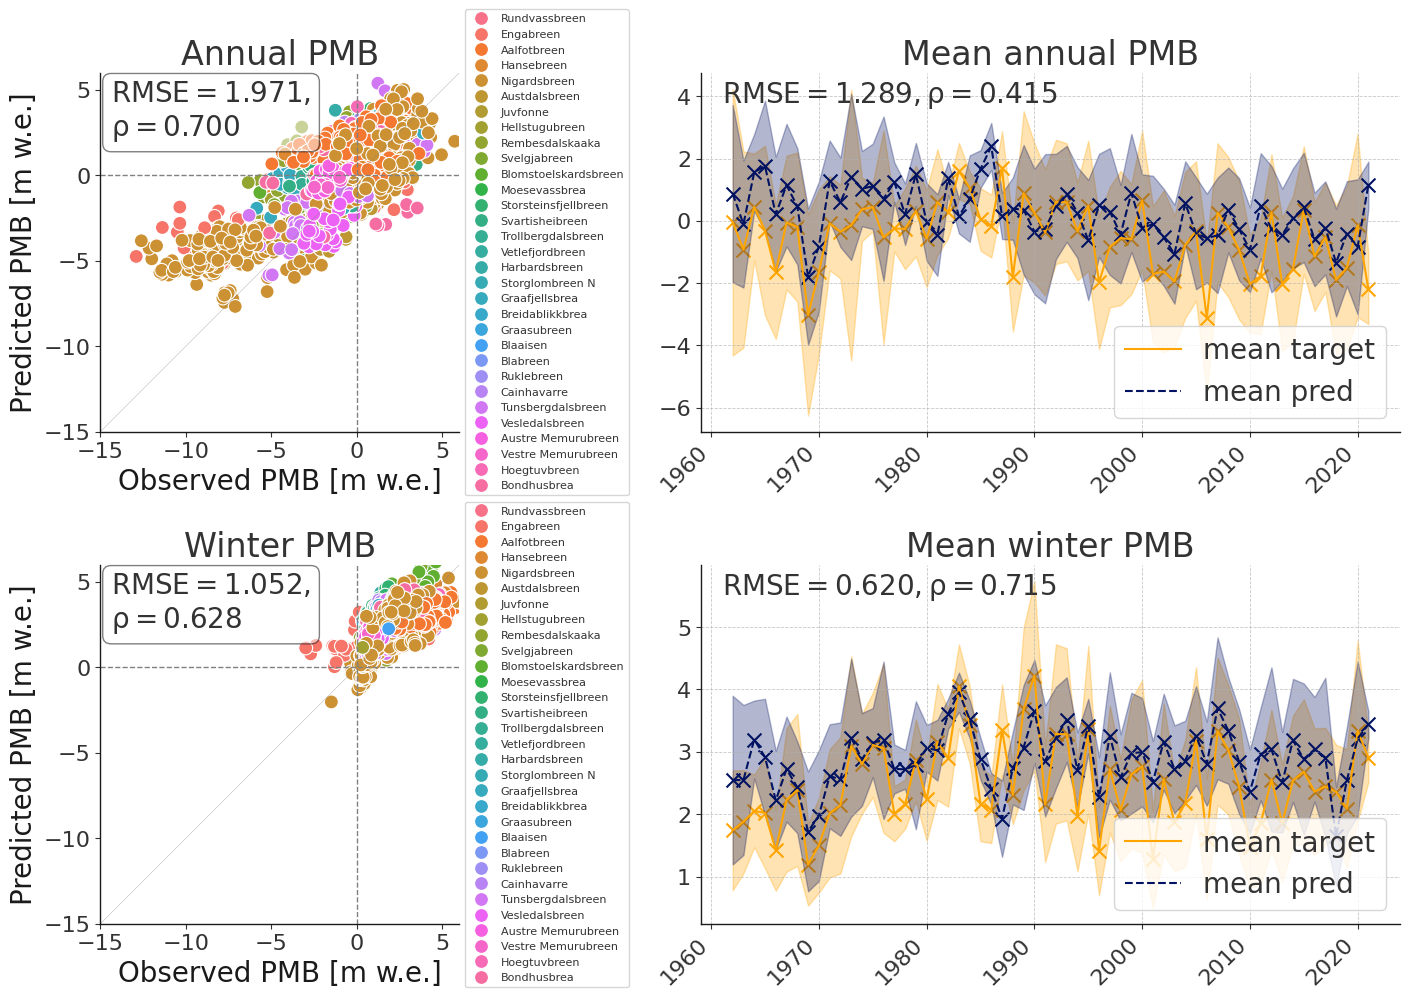

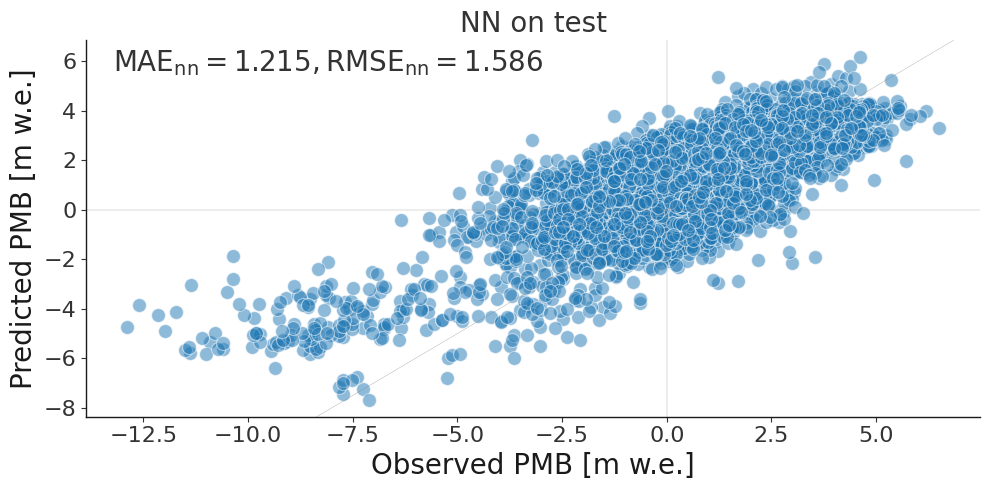

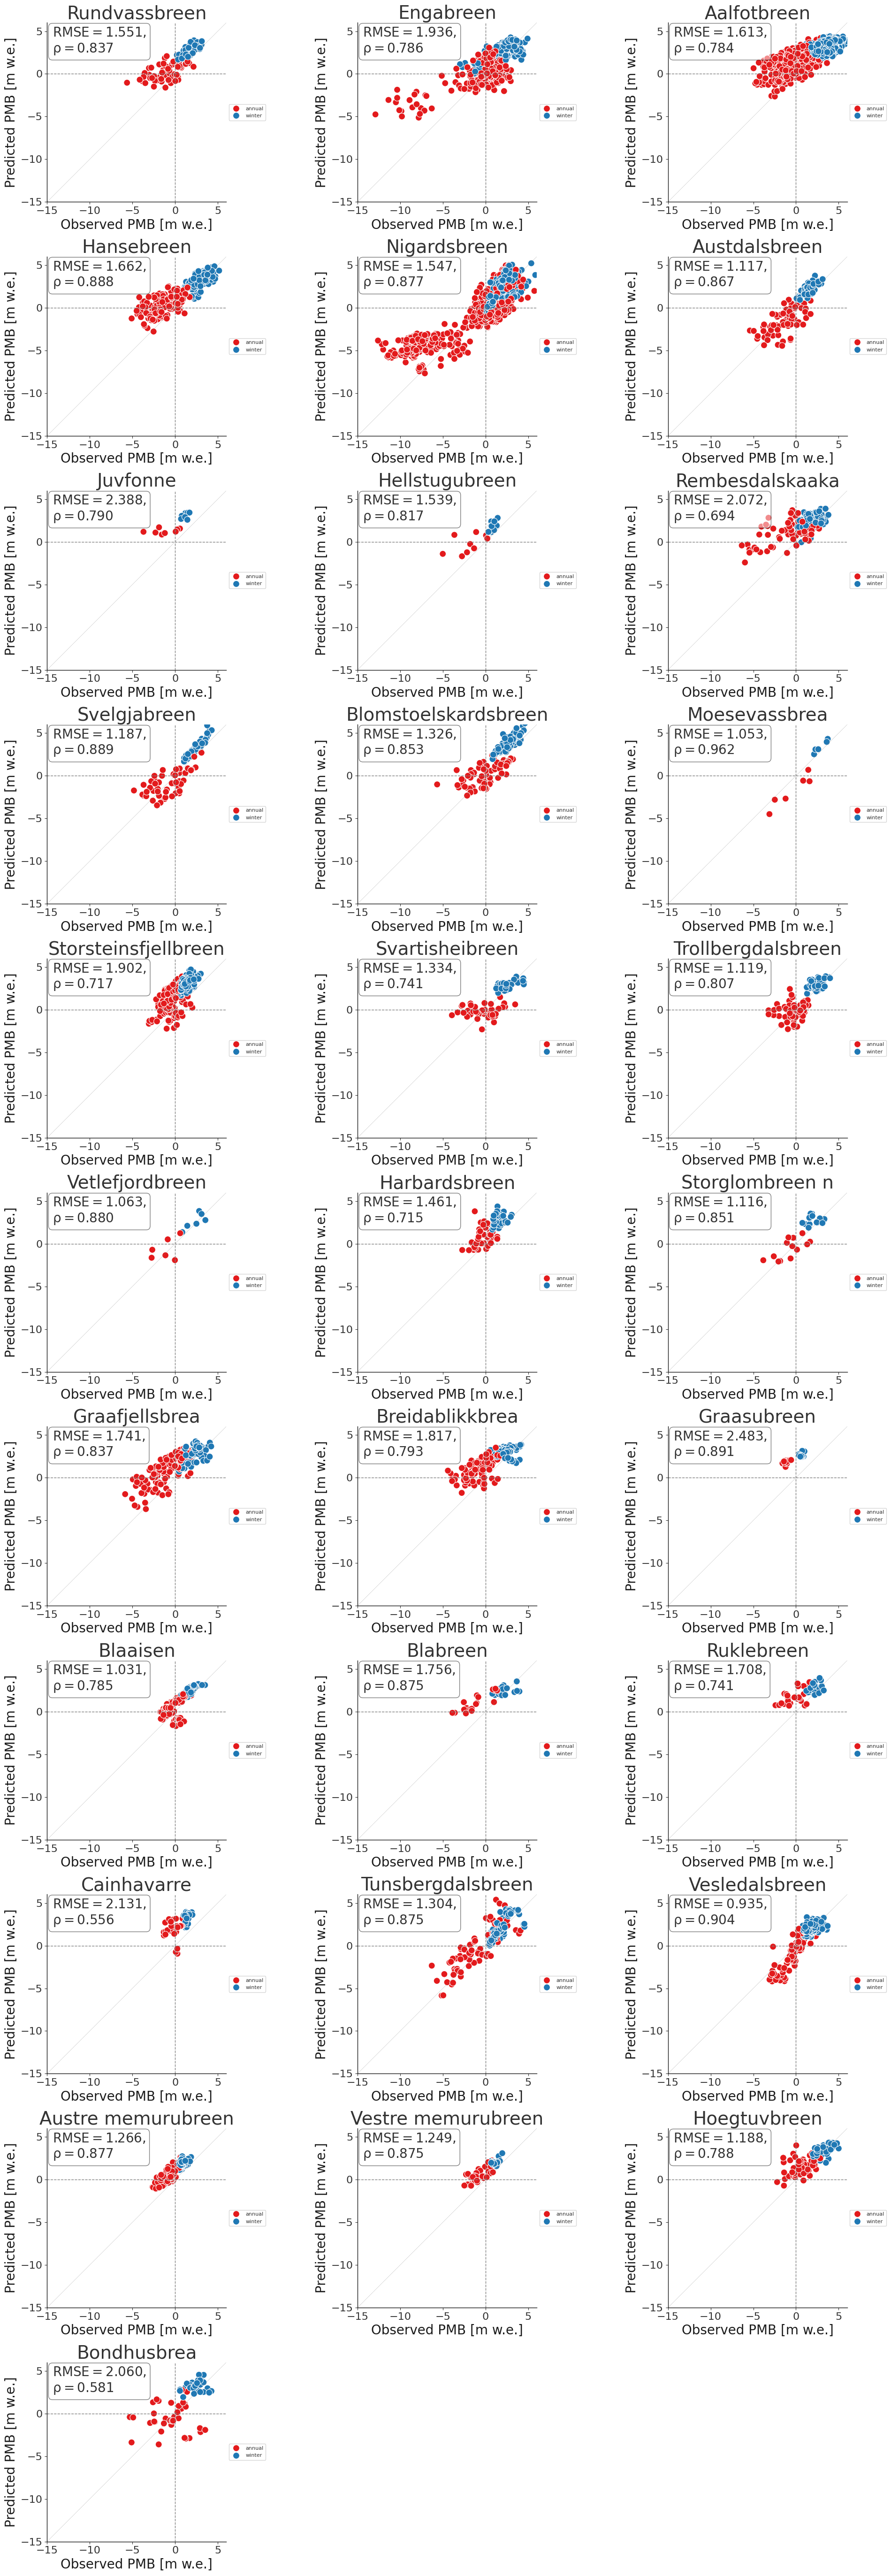

In [ ]:
PlotPredictions_NN(grouped_ids)
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))